In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [2]:
import numpy as np
from typing import Dict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """評価指標を計算する関数
    
    Args:
        y_true: 真の値
        y_pred: 予測値
    
    Returns:
        Dict[str, float]: 各種評価指標
    """
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred)
    }
    return metrics

In [3]:
import pandas as pd
import numpy as np
from typing import Iterator, Tuple, Optional, Union
from sklearn.model_selection import BaseCrossValidator

class TimeSeriesCV(BaseCrossValidator):
    """時系列クロスバリデーション
    
    Args:
        n_splits: 分割数
        test_size: テストサイズ（時間単位）
        gap: トレーニングとテスト期間の間のギャップ
    """
    
    def __init__(self, n_splits: int = 5, test_size: int = 24*7, gap: int = 24):
        self.n_splits = n_splits
        self.test_size = test_size
        self.gap = gap
    
    def get_n_splits(self, X: Optional[Union[pd.DataFrame, np.ndarray]] = None,
                    y: Optional[Union[pd.Series, np.ndarray]] = None,
                    groups: Optional[Union[pd.Series, np.ndarray]] = None) -> int:
        """分割数を返す
        
        Args:
            X: 特徴量（未使用）
            y: ターゲット（未使用）
            groups: グループ（未使用）
            
        Returns:
            int: 分割数
        """
        return self.n_splits
    
    def split(self, X: pd.DataFrame, y=None, groups=None) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
        """時系列データを訓練データとテストデータに分割
        
        Args:
            X: 特徴量
            y: ターゲット（未使用）
            groups: グループ（未使用）
            
        Yields:
            train_idx, test_idx: 訓練データとテストデータのインデックス
        """
        timestamps = X.index if isinstance(X, pd.DataFrame) else X[:, 0]
        n_samples = len(timestamps)
        
        # テストデータの終了位置を決定
        test_ends = np.linspace(
            n_samples - self.test_size,
            n_samples,
            self.n_splits + 1
        )[:-1]
        
        for test_end in test_ends:
            test_end = int(test_end)
            test_start = test_end - self.test_size
            train_end = test_start - self.gap
            
            train_idx = np.arange(0, train_end)
            test_idx = np.arange(test_start, test_end)
            
            yield train_idx, test_idx

In [ ]:
import pandas as pd
import numpy as np
from typing import Dict, List, Optional, Union
import lightgbm as lgb

class LightGBMModel:
    """LightGBMモデル
    
    Args:
        params: LightGBMのパラメータ
        num_boost_round: 学習回数
        early_stopping_rounds: 早期停止のラウンド数
    """
    
    def __init__(
        self,
        params: Optional[Dict] = None,
        num_boost_round: int = 1000,
        early_stopping_rounds: int = 50
    ):
        self.params = params or {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1
        }
        self.num_boost_round = num_boost_round
        self.early_stopping_rounds = early_stopping_rounds
        self.model = None
        self.feature_importance = None
    
    def fit(
        self,
        X_train: Union[pd.DataFrame, np.ndarray],
        y_train: Union[pd.Series, np.ndarray],
        X_valid: Optional[Union[pd.DataFrame, np.ndarray]] = None,
        y_valid: Optional[Union[pd.Series, np.ndarray]] = None
    ) -> Dict[str, float]:
        """モデルの学習
        
        Args:
            X_train: 訓練データの特徴量
            y_train: 訓練データのターゲット
            X_valid: 検証データの特徴量
            y_valid: 検証データのターゲット
            
        Returns:
            Dict[str, float]: 評価指標
        """
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_valid, label=y_valid) if X_valid is not None else None
        
        callbacks = [
            lgb.early_stopping(self.early_stopping_rounds) if valid_data else None,
            lgb.log_evaluation(period=100)
        ]
        callbacks = [cb for cb in callbacks if cb is not None]
        
        self.model = lgb.train(
            self.params,
            train_data,
            num_boost_round=self.num_boost_round,
            valid_sets=[valid_data] if valid_data else None,
            callbacks=callbacks
        )
        
        # 特徴量重要度の保存
        self.feature_importance = pd.DataFrame({
            'feature': self.model.feature_name(),
            'importance': self.model.feature_importance('gain')
        }).sort_values('importance', ascending=False)
        
        # 評価指標の計算
        train_pred = self.predict(X_train)
        metrics = calculate_metrics(y_train, train_pred)
        
        if X_valid is not None:
            valid_pred = self.predict(X_valid)
            valid_metrics = calculate_metrics(y_valid, valid_pred)
            metrics.update({f'valid_{k}': v for k, v in valid_metrics.items()})
        
        return metrics
    
    def predict(self, X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        """予測の実行
        
        Args:
            X: 特徴量
            
        Returns:
            np.ndarray: 予測値
        """
        return self.model.predict(X)
    
    def get_feature_importance(self, top_n: Optional[int] = None) -> pd.DataFrame:
        """特徴量重要度の取得
        
        Args:
            top_n: 上位n個の特徴量を返す
            
        Returns:
            pd.DataFrame: 特徴量重要度
        """
        if self.feature_importance is None:
            raise ValueError("モデルが学習されていません")
        
        if top_n:
            return self.feature_importance.head(top_n)
        return self.feature_importance

訓練データのカラム: ['測定局コード', '日付', '時', 'SO2(ppm)', 'NO(ppm)', 'NO2(ppm)', 'NOx(ppm)', 'CO(ppm)', 'Ox(ppm)', 'NMHC(ppmC)', 'CH4(ppmC)', 'THC(ppmC)', 'SPM(mg/m3)', 'PM2.5(μg/m3)', 'WD(16Dir)', 'WS(m/s)', 'TEMP(℃)', 'HUM(％)', 'timestamp', '月', 'hour', 'day', 'month', 'dayofweek', 'quarter', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'is_weekend', 'is_holiday', 'time_period', 'WD_encoded', 'temp_hum_interaction', 'SO2(ppm)_lag_1', 'SO2(ppm)_lag_2', 'SO2(ppm)_lag_3', 'SO2(ppm)_lag_6', 'SO2(ppm)_lag_12', 'SO2(ppm)_lag_24', 'NO(ppm)_lag_1', 'NO(ppm)_lag_2', 'NO(ppm)_lag_3', 'NO(ppm)_lag_6', 'NO(ppm)_lag_12', 'NO(ppm)_lag_24', 'NO2(ppm)_lag_1', 'NO2(ppm)_lag_2', 'NO2(ppm)_lag_3', 'NO2(ppm)_lag_6', 'NO2(ppm)_lag_12', 'NO2(ppm)_lag_24', 'NOx(ppm)_lag_1', 'NOx(ppm)_lag_2', 'NOx(ppm)_lag_3', 'NOx(ppm)_lag_6', 'NOx(ppm)_lag_12', 'NOx(ppm)_lag_24', 'CO(ppm)_lag_1', 'CO(ppm)_lag_2', 'CO(ppm)_lag_3', 'CO(ppm)_lag_6', 'CO(ppm)_lag_12', 'CO(ppm)_lag_24', 'Ox(ppm)_lag_1', 'Ox(ppm)_lag_2', 'Ox(ppm)_lag_3

/var/folders/y6/zsgr4wr10g33jjjd_mgpjp640000gp/T/ipykernel_15629/1148115190.py:45: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill')
/var/folders/y6/zsgr4wr10g33jjjd_mgpjp640000gp/T/ipykernel_15629/1148115190.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='bfill')
/var/folders/y6/zsgr4wr10g33jjjd_mgpjp640000gp/T/ipykernel_15629/1148115190.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
/var/folders/y6/zsgr4wr10g33jjjd_mgpjp640000gp/T/ipykernel_15629/11


前処理後の欠損値の数:
測定局コード                  0
時                       0
SO2(ppm)                0
NO(ppm)                 0
NO2(ppm)                0
                       ..
station_code_encoded    0
sin_hour                0
cos_hour                0
sin_month               0
cos_month               0
Length: 452, dtype: int64

テストデータの前処理:


/var/folders/y6/zsgr4wr10g33jjjd_mgpjp640000gp/T/ipykernel_15629/1148115190.py:102: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_train = y_train.fillna(method='ffill').fillna(method='bfill')



欠損値の数:
測定局コード                       0
日付                           0
時                            0
SO2(ppm)                110473
NO(ppm)                  49561
                         ...  
HUM(％)_diff_3           222197
HUM(％)_diff_6           222341
HUM(％)_diff_12          222521
HUM(％)_diff_24          222411
station_code_encoded         0
Length: 450, dtype: int64


/var/folders/y6/zsgr4wr10g33jjjd_mgpjp640000gp/T/ipykernel_15629/1148115190.py:45: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill')
/var/folders/y6/zsgr4wr10g33jjjd_mgpjp640000gp/T/ipykernel_15629/1148115190.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='bfill')
/var/folders/y6/zsgr4wr10g33jjjd_mgpjp640000gp/T/ipykernel_15629/1148115190.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
/var/folders/y6/zsgr4wr10g33jjjd_mgpjp640000gp/T/ipykernel_15629/11


前処理後の欠損値の数:
測定局コード                  0
時                       0
SO2(ppm)                0
NO(ppm)                 0
NO2(ppm)                0
                       ..
station_code_encoded    0
sin_hour                0
cos_hour                0
sin_month               0
cos_month               0
Length: 452, dtype: int64

特徴量の型:
測定局コード                    int64
時                         int64
SO2(ppm)                float64
NO(ppm)                 float64
NO2(ppm)                float64
                         ...   
station_code_encoded      int64
sin_hour                float64
cos_hour                float64
sin_month               float64
cos_month               float64
Length: 452, dtype: object

Fold 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 6.24536
[200]	valid_0's rmse: 6.19523
[300]	valid_0's rmse: 5.92666
Early stopping, best iteration is:
[300]	valid_0's rmse: 5.92666

Fold 2
Training until validation scores don't improve for 50 ro

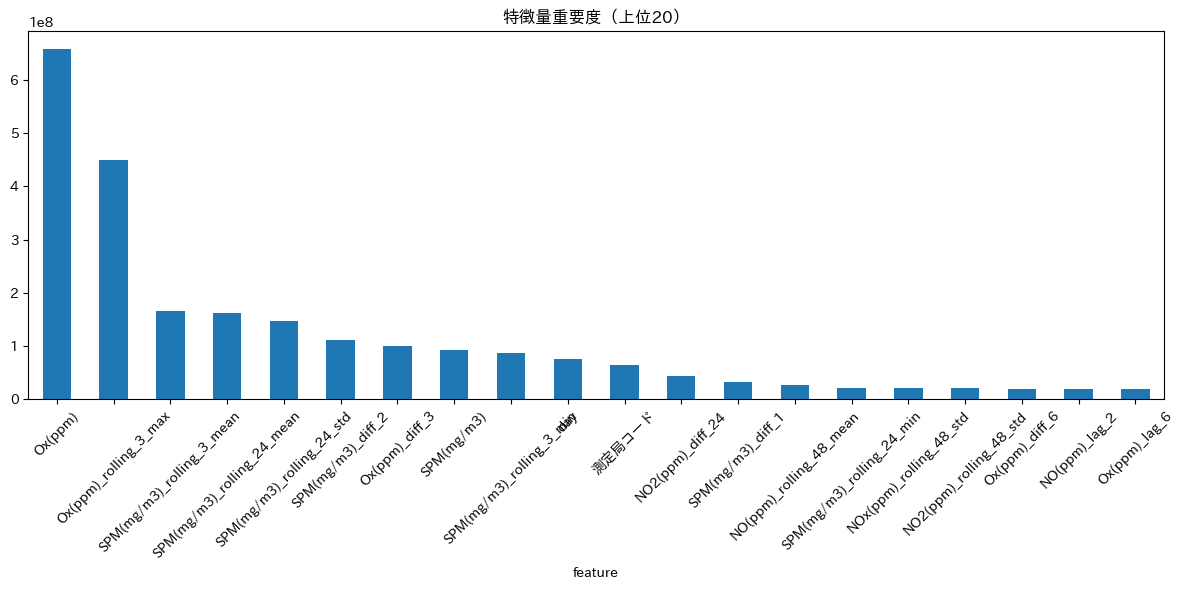

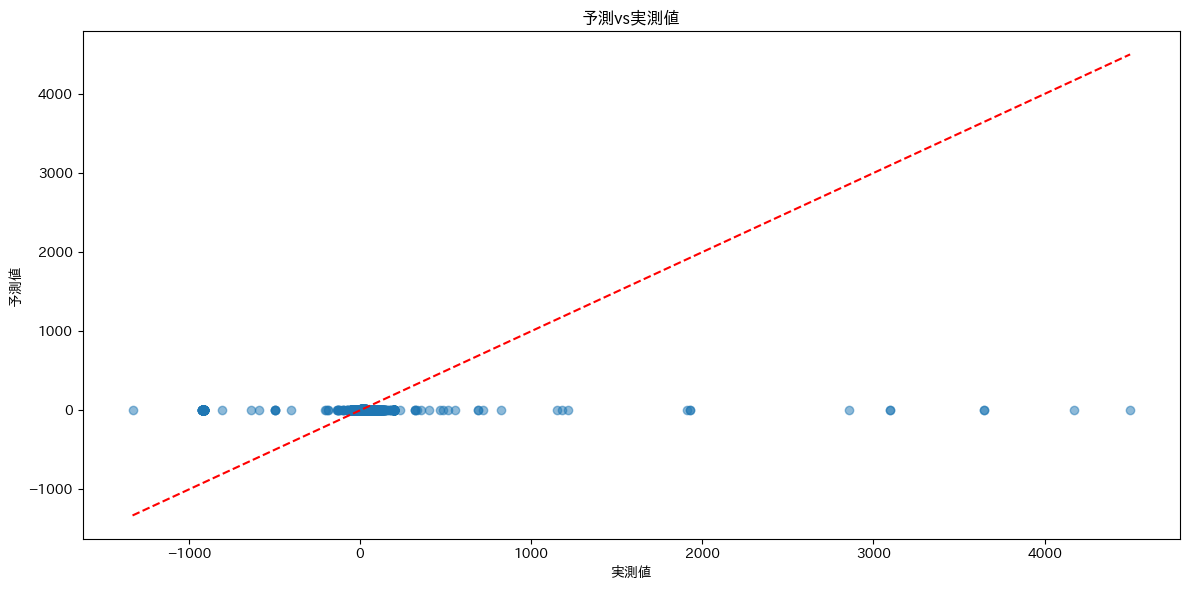

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# データの読み込み
train = pd.read_pickle('../data/model_input/train_features.pkl')
test = pd.read_pickle('../data/model_input/test_features.pkl')

# カラム名の確認
print("訓練データのカラム:", train.columns.tolist())
print("テストデータのカラム:", test.columns.tolist())

# 特徴量とターゲットの分離
target_col = 'PM2.5(μg/m3)'
feature_cols = [col for col in train.columns if col != target_col]

def preprocess_data(df: pd.DataFrame, le_dict: dict = None) -> tuple:
    """データの前処理を行う関数
    
    Args:
        df: 入力データフレーム
        le_dict: LabelEncoderの辞書（Noneの場合は新規作成）
        
    Returns:
        前処理済みデータフレーム, エンコーダー辞書
    """
    df = df.copy()
    
    # 欠損値の確認
    print("\n欠損値の数:")
    print(df.isnull().sum())
    
    # 数値列の欠損値を処理
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            # 時系列データなので、前方補完→後方補完の順で埋める
            df[col] = df[col].fillna(method='ffill')
            df[col] = df[col].fillna(method='bfill')
            # それでも残る欠損値は平均値で埋める
            df[col] = df[col].fillna(df[col].mean())
    
    # 日時特徴量の作成
    if 'timestamp' in df.columns:
        df['hour'] = df['timestamp'].dt.hour
        df['day'] = df['timestamp'].dt.day
        df['month'] = df['timestamp'].dt.month
        df['dayofweek'] = df['timestamp'].dt.dayofweek
        # 周期的な特徴量を作成
        df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
        df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
        df = df.drop('timestamp', axis=1)
    
    if '日付' in df.columns:
        df = df.drop('日付', axis=1)
    
    # カテゴリカル変数の処理
    categorical_cols = df.select_dtypes(include=['object']).columns
    if le_dict is None:
        le_dict = {}
    
    for col in categorical_cols:
        # 欠損値を特別な値で埋める
        df[col] = df[col].fillna('missing')
        
        if col not in le_dict:
            # 新しいカラムの場合、LabelEncoderを作成
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            le_dict[col] = le
        else:
            # 既存のカラムの場合、保存されたLabelEncoderを使用
            le = le_dict[col]
            df[col] = df[col].astype(str)
            # 新しいカテゴリの処理
            new_categories = set(df[col]) - set(le.classes_)
            if new_categories:
                print(f"\n新しいカテゴリが見つかりました（{col}）: {new_categories}")
                df[col] = df[col].map(lambda x: 'missing' if x in new_categories else x)
            df[col] = le.transform(df[col])
    
    # 最終確認
    print("\n前処理後の欠損値の数:")
    print(df.isnull().sum())
    
    return df, le_dict

# データの前処理を実行
print("訓練データの前処理:")
X_train, le_dict = preprocess_data(train[feature_cols])
y_train = train[target_col].copy()
# ターゲットの欠損値も処理
y_train = y_train.fillna(method='ffill').fillna(method='bfill')

print("\nテストデータの前処理:")
X_test, _ = preprocess_data(test[feature_cols], le_dict)

# 特徴量の型を確認
print("\n特徴量の型:")
print(X_train.dtypes)

# クロスバリデーションの設定
cv = TimeSeriesCV(n_splits=5, test_size=24*7, gap=24)

# モデルのパラメータ
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# クロスバリデーションの実行
cv_results = []
cv_predictions = np.zeros(len(X_train))
feature_importance_list = []

for fold, (train_idx, valid_idx) in enumerate(cv.split(X_train)):
    print(f"\nFold {fold + 1}")
    
    # データの分割
    X_tr = X_train.iloc[train_idx]
    y_tr = y_train.iloc[train_idx]
    X_val = X_train.iloc[valid_idx]
    y_val = y_train.iloc[valid_idx]
    
    # モデルの学習
    model = LightGBMModel(params=params)
    metrics = model.fit(X_tr, y_tr, X_val, y_val)
    
    # 予測と評価
    cv_predictions[valid_idx] = model.predict(X_val)
    cv_results.append(metrics)
    
    # 特徴量重要度の保存
    importance_df = model.get_feature_importance()
    importance_df['fold'] = fold + 1
    feature_importance_list.append(importance_df)

# 結果の表示
cv_metrics = pd.DataFrame(cv_results)
print("\nクロスバリデーション結果:")
print(cv_metrics.mean())
print("\n標準偏差:")
print(cv_metrics.std())

# 特徴量重要度の集計と可視化
feature_importance = pd.concat(feature_importance_list)
mean_importance = feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
mean_importance.head(20).plot(kind='bar')
plt.title('特徴量重要度（上位20）')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 予測vs実測値のプロット
plt.figure(figsize=(12, 6))
plt.scatter(y_train, cv_predictions, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel('実測値')
plt.ylabel('予測値')
plt.title('予測vs実測値')
plt.tight_layout()
plt.show()

# テストデータの予測
final_model = LightGBMModel(params=params)
final_model.fit(X_train, y_train)
test_predictions = final_model.predict(X_test)

# 予測結果の保存
submission = pd.read_csv('../data/raw/sample_submission.csv')
submission['PM2.5(μg/m3)'] = test_predictions
submission.to_csv('../data/output/submission_base.csv', index=False)